# MARBERT Training for eng2arb Dataset (Advanced Preprocessing) - Google Colab

This notebook trains and evaluates MARBERT and MARBERT v2 models on the **advanced preprocessed** eng2arb Arabic dataset.

**Dataset**: `arb_eng2arb_clean_advanced.csv` (morphological segmentation)
**Models**:
- MARBERT (UBC-NLP/MARBERT)
- MARBERT v2 (UBC-NLP/MARBERTv2)

**Task**: Binary classification (polarization detection)

**Steps**:
1. Install dependencies
2. Upload preprocessed dataset
3. Train MARBERT and MARBERT v2
4. Compare results
5. Download trained models

## 1. Setup: Install Required Packages

In [ ]:
!pip install transformers torch scikit-learn pandas numpy tqdm accelerate matplotlib seaborn -q
print("✓ Packages installed successfully")

✓ Packages installed successfully


## 2. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ Warning: GPU not available. Training will be slow on CPU.")
    print("   Go to Runtime -> Change runtime type -> Hardware accelerator: GPU")

Using device: cuda
GPU: Tesla T4
Memory: 14.74 GB


## 3. Upload Preprocessed Dataset

Upload your `arb_eng2arb_clean_advanced.csv` file (the output from advanced preprocessing).

In [ ]:
print("Please upload your arb_eng2arb_clean_advanced.csv file:")
print("You should see a 'Choose Files' button below.\n")

uploaded = files.upload()

if 'arb_eng2arb_clean_advanced.csv' in uploaded:
    print("\n✓ Dataset uploaded successfully!")
    print(f"  File size: {len(uploaded['arb_eng2arb_clean_advanced.csv']) / 1024:.2f} KB")
else:
    print("\n⚠️ Warning: arb_eng2arb_clean_advanced.csv not found")
    print(f"Files received: {list(uploaded.keys())}")

Please upload your arb_eng2arb_clean_advanced.csv file:
You should see a 'Choose Files' button below.



Saving arb_eng2arb_clean_advanced.csv to arb_eng2arb_clean_advanced.csv

✓ Dataset uploaded successfully!
  File size: 1148.07 KB


## 4. Load and Explore Dataset

In [ ]:
# Load the advanced preprocessed eng2arb dataset
data_path = 'arb_eng2arb_clean_advanced.csv'
df = pd.read_csv(data_path)

print(f"✓ Dataset loaded successfully!")
print(f"  Shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nClass distribution:")
print(df['polarization'].value_counts())
print(f"\nClass balance:")
print(df['polarization'].value_counts(normalize=True))

# Show some sample preprocessed texts
print(f"\n{'='*80}")
print("Sample advanced preprocessed texts:")
print(f"{'='*80}")
for i in range(3):
    print(f"\nText {i+1}: {df['text'].iloc[i][:100]}...")
    print(f"Label: {df['polarization'].iloc[i]}")

✓ Dataset loaded successfully!
  Shape: (6056, 3)
  Columns: ['id', 'text', 'polarization']

First few rows:
                                     id  \
0  arb_a2a60c8b4af3389e842d8ec31afb0eea   
1  arb_6723e56a672674a6c1d9b28b213c4a05   
2  arb_b0365d606edeee38ae6c025b1ca33e96   
3  arb_858c0ee684049ba6f416a6cecb0b0761   
4  arb_bdafc73afd0bc2cd2badae2a089446b9   

                                                text  polarization  
0  أحلام أنتي و+ نعالي ومنو أنتي حتى تقيمين الفنا...             1  
1  وره الكواليس تنيجج من وره بعير صطناعي على ف+ ك...             1  
2  .خخخخ الملكة أحلام فيها شذوذ شنو هل بوس و+ الد...             1  
3  الله يخزى أحلام هي و+ البرنامج الخايس إلى كله ...             1  
4  كس أم أحلام إلى ماربتها وش ملكه هههه متستاهل م...             1  

Class distribution:
polarization
0    3542
1    2514
Name: count, dtype: int64

Class balance:
polarization
0    0.584875
1    0.415125
Name: proportion, dtype: float64

Sample advanced preprocessed texts:

Text 1: أح

## 5. Split Data (90/10 Train/Test with Stratification)

In [ ]:
# Split with stratification to maintain class balance
RANDOM_STATE = 42

train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=df['polarization']
)

print(f"Train set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nTrain set class distribution:")
print(train_df['polarization'].value_counts())
print(f"\nTest set class distribution:")
print(test_df['polarization'].value_counts())

print(f"\nClass balance verification:")
print(f"Train: {train_df['polarization'].value_counts(normalize=True).to_dict()}")
print(f"Test:  {test_df['polarization'].value_counts(normalize=True).to_dict()}")

Train set size: 5450 (90.0%)
Test set size: 606 (10.0%)

Train set class distribution:
polarization
0    3188
1    2262
Name: count, dtype: int64

Test set class distribution:
polarization
0    354
1    252
Name: count, dtype: int64

Class balance verification:
Train: {0: 0.584954128440367, 1: 0.415045871559633}
Test:  {0: 0.5841584158415841, 1: 0.4158415841584158}


## 6. Prepare Datasets for Training

In [ ]:
# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'polarization']].rename(columns={'polarization': 'label'}))
test_dataset = Dataset.from_pandas(test_df[['text', 'polarization']].rename(columns={'polarization': 'label'}))

print(f"✓ Datasets prepared")
print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

✓ Datasets prepared
Train dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 5450
})
Test dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 606
})


## 7. Helper Functions for Training and Evaluation

In [ ]:
def tokenize_function(examples, tokenizer):
    """Tokenize the texts"""
    return tokenizer(examples['text'], truncation=True, padding=False, max_length=512)

def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model(trainer, test_dataset, model_name):
    """Evaluate model and print detailed metrics"""
    print(f"\n{'='*80}")
    print(f"Evaluating {model_name}")
    print(f"{'='*80}")

    # Get predictions
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Print metrics
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Class 0', 'Class 1']))

    # Plot confusion matrix
    plot_confusion_matrix(labels, preds, title=f"{model_name} - Confusion Matrix")

    # Return metrics
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted'),
        'predictions': predictions
    }

print("✓ Helper functions defined")

✓ Helper functions defined


## 8. Train MARBERT Model

In [ ]:
# Load MARBERT tokenizer and model
marbert_model_name = "UBC-NLP/MARBERT"
print(f"Loading {marbert_model_name}...")

marbert_tokenizer = AutoTokenizer.from_pretrained(marbert_model_name)
marbert_model = AutoModelForSequenceClassification.from_pretrained(
    marbert_model_name,
    num_labels=2
)

# Tokenize datasets
print("Tokenizing datasets...")
marbert_train_dataset = train_dataset.map(
    lambda x: tokenize_function(x, marbert_tokenizer),
    batched=True
)
marbert_test_dataset = test_dataset.map(
    lambda x: tokenize_function(x, marbert_tokenizer),
    batched=True
)

print(f"✓ Model loaded and datasets tokenized")
print(f"  Train dataset size: {len(marbert_train_dataset)}")
print(f"  Test dataset size: {len(marbert_test_dataset)}")

Loading UBC-NLP/MARBERT...


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing datasets...


Map:   0%|          | 0/5450 [00:00<?, ? examples/s]

Map:   0%|          | 0/606 [00:00<?, ? examples/s]

✓ Model loaded and datasets tokenized
  Train dataset size: 5450
  Test dataset size: 606


In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results_marbert_eng2arb',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_marbert_eng2arb',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=RANDOM_STATE
)

# Create data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=marbert_tokenizer)

# Create Trainer
marbert_trainer = Trainer(
    model=marbert_model,
    args=training_args,
    train_dataset=marbert_train_dataset,
    eval_dataset=marbert_test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# Train the model
print("Training MARBERT on eng2arb advanced preprocessed data...")
print("This may take 15-25 minutes depending on GPU...\n")
marbert_trainer.train()
print("✓ MARBERT training complete!")

Training MARBERT on eng2arb advanced preprocessed data...
This may take 15-25 minutes depending on GPU...



wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nuh-alsharafi (deepclean415445) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.485000,0.628928,0.732673,0.720117,0.739421,0.732673
2,0.390000,0.444863,0.788779,0.790193,0.797796,0.788779
3,0.147500,0.957317,0.792079,0.792079,0.792079,0.792079


✓ MARBERT training complete!


## 9. Evaluate MARBERT Model


Evaluating MARBERT (eng2arb Advanced)



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.82      0.82      0.82       354
     Class 1       0.75      0.75      0.75       252

    accuracy                           0.79       606
   macro avg       0.79      0.79      0.79       606
weighted avg       0.79      0.79      0.79       606



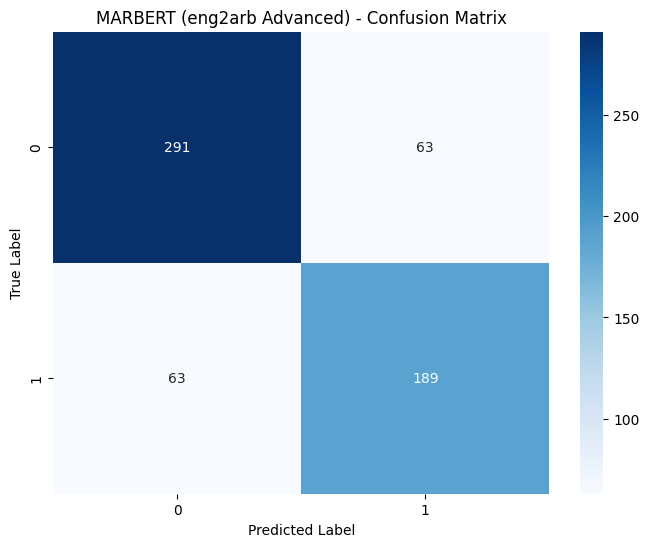


✓ MARBERT Results:
  Accuracy:  0.7921
  F1 Score:  0.7921
  Precision: 0.7921
  Recall:    0.7921


In [ ]:
# Evaluate MARBERT
marbert_results = evaluate_model(marbert_trainer, marbert_test_dataset, "MARBERT (eng2arb Advanced)")
print(f"\n✓ MARBERT Results:")
print(f"  Accuracy:  {marbert_results['accuracy']:.4f}")
print(f"  F1 Score:  {marbert_results['f1']:.4f}")
print(f"  Precision: {marbert_results['precision']:.4f}")
print(f"  Recall:    {marbert_results['recall']:.4f}")

## 10. Train MARBERT v2 Model

In [ ]:
# Load MARBERT v2 tokenizer and model
marbertv2_model_name = "UBC-NLP/MARBERTv2"
print(f"Loading {marbertv2_model_name}...")

marbertv2_tokenizer = AutoTokenizer.from_pretrained(marbertv2_model_name)
marbertv2_model = AutoModelForSequenceClassification.from_pretrained(
    marbertv2_model_name,
    num_labels=2
)

# Tokenize datasets
print("Tokenizing datasets...")
marbertv2_train_dataset = train_dataset.map(
    lambda x: tokenize_function(x, marbertv2_tokenizer),
    batched=True
)
marbertv2_test_dataset = test_dataset.map(
    lambda x: tokenize_function(x, marbertv2_tokenizer),
    batched=True
)

print(f"✓ Model loaded and datasets tokenized")
print(f"  Train dataset size: {len(marbertv2_train_dataset)}")
print(f"  Test dataset size: {len(marbertv2_test_dataset)}")

Loading UBC-NLP/MARBERTv2...


tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing datasets...


Map:   0%|          | 0/5450 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Map:   0%|          | 0/606 [00:00<?, ? examples/s]

✓ Model loaded and datasets tokenized
  Train dataset size: 5450
  Test dataset size: 606


In [ ]:
# Set up training arguments for MARBERT v2
training_args_v2 = TrainingArguments(
    output_dir='./results_marbertv2_eng2arb',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_marbertv2_eng2arb',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=RANDOM_STATE
)

# Create data collator for dynamic padding
data_collator_v2 = DataCollatorWithPadding(tokenizer=marbertv2_tokenizer)

# Create Trainer
marbertv2_trainer = Trainer(
    model=marbertv2_model,
    args=training_args_v2,
    train_dataset=marbertv2_train_dataset,
    eval_dataset=marbertv2_test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator_v2
)

# Train the model
print("Training MARBERT v2 on eng2arb advanced preprocessed data...")
print("This may take 15-25 minutes depending on GPU...\n")
marbertv2_trainer.train()
print("✓ MARBERT v2 training complete!")

Training MARBERT v2 on eng2arb advanced preprocessed data...
This may take 15-25 minutes depending on GPU...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.472400,0.433771,0.785479,0.783250,0.784514,0.785479
2,0.351200,0.411889,0.800330,0.801723,0.811156,0.800330
3,0.165600,0.663686,0.808581,0.808688,0.808813,0.808581


✓ MARBERT v2 training complete!


## 11. Evaluate MARBERT v2 Model


Evaluating MARBERT v2 (eng2arb Advanced)



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.83      0.84       354
     Class 1       0.77      0.77      0.77       252

    accuracy                           0.81       606
   macro avg       0.80      0.80      0.80       606
weighted avg       0.81      0.81      0.81       606



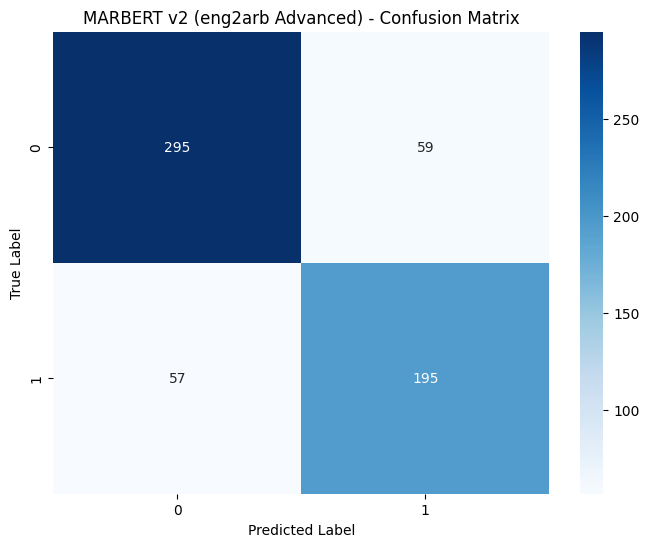


✓ MARBERT v2 Results:
  Accuracy:  0.8086
  F1 Score:  0.8087
  Precision: 0.8088
  Recall:    0.8086


In [ ]:
# Evaluate MARBERT v2
marbertv2_results = evaluate_model(marbertv2_trainer, marbertv2_test_dataset, "MARBERT v2 (eng2arb Advanced)")
print(f"\n✓ MARBERT v2 Results:")
print(f"  Accuracy:  {marbertv2_results['accuracy']:.4f}")
print(f"  F1 Score:  {marbertv2_results['f1']:.4f}")
print(f"  Precision: {marbertv2_results['precision']:.4f}")
print(f"  Recall:    {marbertv2_results['recall']:.4f}")

## 12. Compare Results: MARBERT vs MARBERT v2


FINAL RESULTS - eng2arb Dataset (Advanced Preprocessing)
     Model  Accuracy  F1 Score  Precision   Recall
   MARBERT  0.792079  0.792079   0.792079 0.792079
MARBERT v2  0.808581  0.808688   0.808813 0.808581


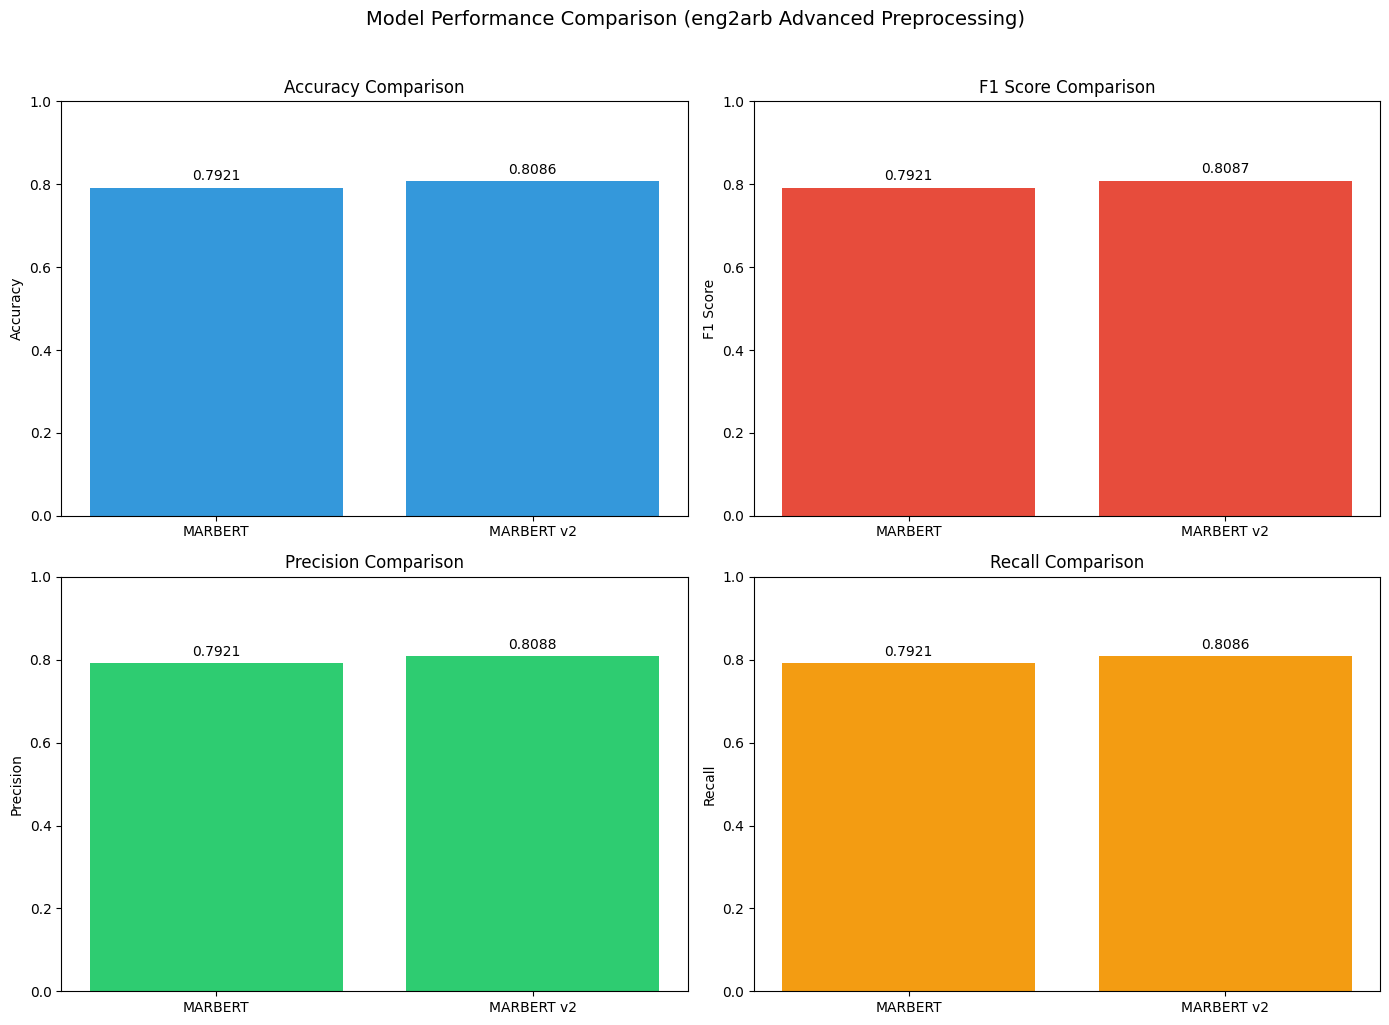


🏆 Winner: MARBERT v2
   Improvement: +0.0166 F1 score

Dataset: eng2arb (English translated to Arabic)
Preprocessing: ADVANCED (morphological segmentation)
Train Size: 5450 | Test Size: 606


In [ ]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['MARBERT', 'MARBERT v2'],
    'Accuracy': [marbert_results['accuracy'], marbertv2_results['accuracy']],
    'F1 Score': [marbert_results['f1'], marbertv2_results['f1']],
    'Precision': [marbert_results['precision'], marbertv2_results['precision']],
    'Recall': [marbert_results['recall'], marbertv2_results['recall']]
})

print("\n" + "="*80)
print("FINAL RESULTS - eng2arb Dataset (Advanced Preprocessing)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Plot comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

models = ['MARBERT', 'MARBERT v2']
metrics = [
    ('Accuracy', [marbert_results['accuracy'], marbertv2_results['accuracy']], ax1, '#3498db'),
    ('F1 Score', [marbert_results['f1'], marbertv2_results['f1']], ax2, '#e74c3c'),
    ('Precision', [marbert_results['precision'], marbertv2_results['precision']], ax3, '#2ecc71'),
    ('Recall', [marbert_results['recall'], marbertv2_results['recall']], ax4, '#f39c12')
]

for metric_name, scores, ax, color in metrics:
    ax.bar(models, scores, color=color)
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} Comparison')
    ax.set_ylim([0, 1])
    for i, v in enumerate(scores):
        ax.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.suptitle('Model Performance Comparison (eng2arb Advanced Preprocessing)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Determine winner
if marbert_results['f1'] > marbertv2_results['f1']:
    winner = "MARBERT"
    improvement = marbert_results['f1'] - marbertv2_results['f1']
elif marbertv2_results['f1'] > marbert_results['f1']:
    winner = "MARBERT v2"
    improvement = marbertv2_results['f1'] - marbert_results['f1']
else:
    winner = "TIE"
    improvement = 0

print(f"\n🏆 Winner: {winner}")
if winner != "TIE":
    print(f"   Improvement: +{improvement:.4f} F1 score")

print(f"\n{'='*80}")
print("Dataset: eng2arb (English translated to Arabic)")
print("Preprocessing: ADVANCED (morphological segmentation)")
print(f"Train Size: {len(train_df)} | Test Size: {len(test_df)}")
print(f"{'='*80}")

## 13. Save and Download Models

In [ ]:
# Save models
print("Saving models...\n")

marbert_trainer.save_model('./marbert_eng2arb_final')
print("✓ MARBERT saved to: ./marbert_eng2arb_final")

marbertv2_trainer.save_model('./marbertv2_eng2arb_final')
print("✓ MARBERT v2 saved to: ./marbertv2_eng2arb_final")

print("\nModels saved successfully!")

In [ ]:
# Create results summary file
results_summary = f"""
MARBERT Training Results - eng2arb Dataset
==========================================

Dataset: eng2arb (English translated to Arabic)
Preprocessing: Advanced (Morphological Segmentation)
Train Size: {len(train_df)}
Test Size: {len(test_df)}

MARBERT Results:
  Accuracy:  {marbert_results['accuracy']:.4f}
  F1 Score:  {marbert_results['f1']:.4f}
  Precision: {marbert_results['precision']:.4f}
  Recall:    {marbert_results['recall']:.4f}

MARBERT v2 Results:
  Accuracy:  {marbertv2_results['accuracy']:.4f}
  F1 Score:  {marbertv2_results['f1']:.4f}
  Precision: {marbertv2_results['precision']:.4f}
  Recall:    {marbertv2_results['recall']:.4f}

Winner: {winner}
"""

with open('results_eng2arb_summary.txt', 'w', encoding='utf-8') as f:
    f.write(results_summary)

print("Downloading results summary...")
files.download('results_eng2arb_summary.txt')
print("✓ Results summary downloaded!")

## Optional: Download Model Checkpoints

If you want to download the trained models, compress and download them:

In [ ]:
# Compress and download models (uncomment to use)
# Warning: Model files are large (~500MB+ each)

# !zip -r marbert_eng2arb_final.zip ./marbert_eng2arb_final
# !zip -r marbertv2_eng2arb_final.zip ./marbertv2_eng2arb_final

# print("Downloading MARBERT model...")
# files.download('marbert_eng2arb_final.zip')

# print("Downloading MARBERT v2 model...")
# files.download('marbertv2_eng2arb_final.zip')

# print("✓ Models downloaded!")